<p align = "center" draggable=”false” ><img src="https://github.com/AI-Maker-Space/LLM-Dev-101/assets/37101144/d1343317-fa2f-41e1-8af1-1dbb18399719" 
     width="200px"
     height="auto"/>
</p>

<h1 align="center" id="heading">RAG in Practice - 2025</h1>

In this event, we'll be looking at best-practice tools for RAG in 2025.

We'll go over how to build a solid baseline RAG application (essentially what is tablestakes as of May 14th, 2025). 

This is by no means the *end* of the line for RAG - but it is what you should be building *at minimum* as you create RAG applications. 

We'll also select a best practice visibility and monitoring tool [Arize Phoenix](https://docs.arize.com/phoenix)

> Instructions for launching the local Arize Pheonix deployment is available [here](https://docs.arize.com/phoenix/tracing/integrations-tracing/langgraph)

In [1]:
import os
from phoenix.otel import register
from openinference.instrumentation.langchain import LangChainInstrumentor

os.environ["PHOENIX_COLLECTOR_ENDPOINT"] = "http://localhost:6006"

tracer_provider = register(
  project_name="rag-in-practice-2025",
)

LangChainInstrumentor().instrument(tracer_provider=tracer_provider)

🔭 OpenTelemetry Tracing Details 🔭
|  Phoenix Project: rag-in-practice-2025
|  Span Processor: SimpleSpanProcessor
|  Collector Endpoint: localhost:4317
|  Transport: gRPC
|  Transport Headers: {'user-agent': '****'}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  ⚠️ WARNING: It is strongly advised to use a BatchSpanProcessor in production environments.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.



## Ingestion of Documents

Notice how we're not using LangChain's default splitters. While this example is simplified - the idea holds true: 

Chunking/splitting is something that should be done in a thought-out way, relying on base chunking strategies is not a suggested practice. 

Since our data is quotations separated by `\n\n` - we'll build a simple function that splits our data into coherent chunks.

In [2]:
def split_docs(doc_path: str) -> list:
    # Read the document
    with open(doc_path, 'r', encoding='utf-8') as file:
        content = file.read()
    
    # Split the document by double newlines
    chunks = content.split('\n\n')
    
    # Remove any empty chunks
    chunks = [chunk.strip() for chunk in chunks if chunk.strip()]
    
    return chunks

In [3]:
da_vinci_documents = split_docs("./data/da_vinci.txt")
len(da_vinci_documents)

89

In [4]:
da_vinci_documents[0]

'There are three classes of people: those who see. Those who see when they are shown. Those who do not see.'

In [5]:
henry_david_thoreau_documents = split_docs("./data/henry_david_thoreau.txt")
len(henry_david_thoreau_documents)

50

In [6]:
henry_david_thoreau_documents[0]

'1. “All good things are wild and free.”'

As you can see - our Thoreau quotations have distracting characters - we'll clean those. 

> NOTE: Data quality is still incredibly important - again, this is a simple example - but it's meant to demonstate that you should care about your data. 

In [7]:
import re

def clean_hdt_quotations(list_of_quotations):
    cleaned_quotations = []
    
    for quotation in list_of_quotations:
        without_numbering = re.sub(r'^\d+\.\s+', '', quotation)
        
        cleaned_quote = without_numbering.strip('”')
        if cleaned_quote.startswith('“'):
            cleaned_quote = cleaned_quote[1:]
        
        cleaned_quotations.append(cleaned_quote)
    
    return cleaned_quotations

In [8]:
henry_david_thoreau_documents_clean = clean_hdt_quotations(henry_david_thoreau_documents)
henry_david_thoreau_documents_clean[0]

'All good things are wild and free.'

## Embedding Model

We'll be using [llama-3.2-nv-embedqa-1b-v2](https://build.nvidia.com/nvidia/llama-3_2-nv-embedqa-1b-v2) as our Embedding Model today - it's fast, efficient, has long context, supports multiple languages, has incredibly high scores for retrieval tasks, and can be securely and locally hosted as a NIM. 

> Instructions on launching the NIM are available [here](https://build.nvidia.com/nvidia/llama-3_2-nv-embedqa-1b-v2/deploy)

In [9]:
from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings

nvidia_embeddings = NVIDIAEmbeddings(
  base_url="http://192.168.2.42:8000/v1",
  model="nvidia/llama-3.2-nv-embedqa-1b-v2", 
  truncate="NONE", 
)

In [10]:
len(nvidia_embeddings.embed_query("Hello, there!"))

2048

## Creating Vector Store - Qdrant

Qdrant is our recommended Vector Database as it serves as a tool that you can start with, and will scale with you as your needs grow. 

> Instructions on how to get QDrant spun up are available [here](https://qdrant.tech/documentation/quickstart/)

In [11]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

client = QdrantClient(
    url="http://localhost:6333"
)

/home/chris/Code/AI Makerspace/Events/RAG-In-Practice-2025/.venv/lib/python3.13/site-packages/qdrant_client/http/models/models.py:758: SyntaxWarning: invalid escape sequence '\&'
  description="Check that the field is empty, alternative syntax for `is_empty: \&quot;field_name\&quot;`",
/home/chris/Code/AI Makerspace/Events/RAG-In-Practice-2025/.venv/lib/python3.13/site-packages/qdrant_client/http/models/models.py:762: SyntaxWarning: invalid escape sequence '\&'
  description="Check that the field is null, alternative syntax for `is_null: \&quot;field_name\&quot;`",


In [13]:
client.create_collection(
    collection_name="quotation_collection",
    vectors_config=VectorParams(size=2048, distance=Distance.COSINE),
)

True

In [14]:
vector_store = QdrantVectorStore(
    client=client,
    collection_name="quote_collection",
    embedding=nvidia_embeddings,
)

> NOTE: Notice how we inject metadata into Qdrant - this can be leveraged directly or indirectly as we'll see when we use the application. 

In [15]:
from uuid import uuid4
from langchain_core.documents import Document

documents = []
uuids = []

for i, quote in enumerate(henry_david_thoreau_documents_clean):
    document = Document(
        page_content=quote,
        metadata={"author": f"Henry David Thoreau"},
    )
    uuid = str(uuid4())
    documents.append(document)
    uuids.append(uuid)

_ = vector_store.add_documents(documents=documents, ids=uuids)

In [16]:
documents = []
uuids = []

for i, quote in enumerate(da_vinci_documents):
    document = Document(
        page_content=quote,
        metadata={"author": f"Leonardo da Vinci"},
    )
    uuid = str(uuid4())
    documents.append(document)
    uuids.append(uuid)

_ = vector_store.add_documents(documents=documents, ids=uuids)

## Creating our Retriever

We are going to recommend that for retrieval you begin with: 

1. Hybrid Retrieval (Dense + Keyword)
2. Reranking 

While methods like HyDE can be leveraged to great effect in some situations (as was shown in [this paper](https://arxiv.org/pdf/2407.01219)) - they're not as universally useful as the above flow. 

### Hybrid Retrieval

We'll combine our dense retreival (LLM Embeddings) with BM25 and combine them with reciprocal rank-fusion (rRF) to produce a final list. 

> NOTE: We are choosing 5 pieces of context from both retrieval processes - this is an adjustable hyperparameter. The number should be larger than your final desired number of documents since the Reranking process can be used to filter out the lowest scoring options.

In [17]:
from langchain.retrievers import EnsembleRetriever
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_texts(
    texts=henry_david_thoreau_documents_clean+da_vinci_documents,
)
bm25_retriever.k = 5

hybrid_retriever = EnsembleRetriever(
    retrievers=[
        vector_store.as_retriever(search_kwargs={"k": 5}), 
        bm25_retriever
    ],
    weights=[0.5, 0.5],
)

### Reranking

Reranking is an extremely important piece of the puzzle - as it allows us to more deeply search through a subset of our documents. 

> Instructions on how to run the NIM are available [here](https://build.nvidia.com/nvidia/llama-3_2-nv-rerankqa-1b-v2/deploy)

In [18]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_nvidia_ai_endpoints.reranking import NVIDIARerank

cohere_rerank = NVIDIARerank(
    base_url="http://192.168.2.42:8002/v1",
    model="nvidia/llama-3.2-nv-rerankqa-1b-v2",
)

reranker = ContextualCompressionRetriever(
    base_compressor=cohere_rerank, base_retriever=hybrid_retriever
)

## RAG Prompt

Prompts are still crucial - and while this prompt works well for this use-case, time should still be spent on exactly how you're prompting your LLM based on a number of factors. (generator model being used, number of documents retrieved, etc.)

This process is, like data ingestion, something to spend time and effort on. 

In [19]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """
#CONTEXT:
{context}

QUERY:
{query}

Use the provide context to answer the provided user query. Only use the provided context to answer the query. If you do not know the answer, or it's not contained in the provided context response with "I don't know"
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("human", RAG_TEMPLATE)
])

## Generator

While we're recommending [meta-llama/Llama-3.3-70B-Instruct](https://huggingface.co/meta-llama/Llama-3.3-70B-Instruct) as the "default best RAG model" - this is another choice that is use-case, domain, and cost based.

Right-sizing your model is still a difficult process in 2025 - but for most use-cases where you need a good model and can afford/support Llama 3.3 70B Instruct - you should find it extremely effective. 

> NOTE: For this example, so that it can run locally on most systems, we're going to be running `ollama` with the recent `qwen3:14b` - instructions on how to get this running are available [here](https://ollama.com/library/qwen3)!

In [20]:
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model="qwen3:14b",
    temperature=0.0,
)

In [21]:
llm.invoke("What did Thoreau say about the importance of solitude?")

AIMessage(content='<think>\nOkay, so I need to figure out what Thoreau said about the importance of solitude. Let me start by recalling what I know about Henry David Thoreau. He was a 19th-century American author, philosopher, and transcendentalist. He\'s best known for his book "Walden," where he describes his experience living in a cabin near Walden Pond. I think he emphasized living simply and in harmony with nature.\n\nNow, solitude. Thoreau probably talked about it in "Walden." I remember something about him valuing solitude for self-reflection and personal growth. Maybe he believed that being alone allows one to think more clearly or to escape the distractions of society. But I need to be more specific.\n\nI should check some quotes from "Walden." One famous line is "I went to the woods because I wished to live deliberately, to front only the essential facts of life..." That\'s from the beginning. But how does that relate to solitude? Well, living in the woods would mean solitude

## Creating RAG Graph

We continue to suggest people to use LangGraph in 2025. Notice that LCEL is largely removed as the core way to interact with the LangX ecosystem - as we prefer to interact with it through LangGraph. 

In [23]:
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

class RAGState(TypedDict):
  question: str
  context: List[Document]
  response: str

> NOTE: There is a subtle best-practice in the next cell, which is to return your contexts in ascending order. 

In [24]:
def retrieve(state: RAGState) -> RAGState:
  retrieved_docs = reranker.invoke(state["question"])
  return {"context" : retrieved_docs[::-1]}

In [25]:
from langchain_core.output_parsers import StrOutputParser

def generate(state: RAGState) -> RAGState:
  generation_chain = chat_prompt | llm | StrOutputParser()
  response = generation_chain.invoke({"query" : state["question"], "context" : state["context"]})
  return {"response" : response}

In [26]:
graph_builder = StateGraph(RAGState)
graph_builder = graph_builder.add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

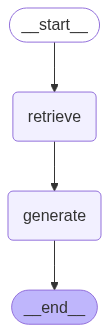

In [27]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Testing our Pipeline

### Not Present in Documents

In this case, we know the question should not be answerable.

In [32]:
response = graph.invoke({"question" : "Why do birds sing?"})
thinking, response = response["response"].split("</think>")

print(thinking)
print(response)

<think>
Okay, the user is asking why birds sing. Let me check the provided context to see if there's any relevant information.

Looking through the documents: the first one is about treating virtuous people with honor, the second is Leonardo da Vinci talking about people in hot and cold countries and their color preferences, the third and fourth are about understanding oneself when lost, and the fifth is Thoreau's quote about people leading quiet desperate lives. None of these documents mention birds or their singing. 

Since there's no information about birds in the context provided, I can't use any of these to answer the query. The correct response is to say I don't know.



I don't know.


### Wrong Author

In this case, we know Da Vinci didn't have quotes about solitude in the corpus we used - but Thoreau did. 

In [33]:
response = graph.invoke({"question" : "What did Da Vinci have to say about solitude?"})
thinking, response = response["response"].split("</think>")

print(thinking)
print(response)

<think>
Okay, the user is asking what Da Vinci had to say about solitude. Let me check the provided context.

Looking at the documents, there's one attributed to Leonardo da Vinci. The page content is a quote where he says, "Study me, reader... because the patience for this profession is found in very few, and only in those who wish to compose things anew. Come, oh men, to see the miracles that such studies will disclose to nature." 

Wait, this quote is more about dedication to study and creating new things, not directly about solitude. The other documents include quotes about solitude, like Thoreau's, but the user specifically asked about Da Vinci. Since the Da Vinci quote doesn't mention solitude, I can't use it to answer the query. The other quotes are from different authors. So, there's no information in the context about Da Vinci's views on solitude. I should respond that I don't know.



I don't know. The provided context includes a quote from Leonardo da Vinci about dedication 

In [29]:
response["context"]

[Document(metadata={'relevance_score': -20.9375}, page_content='What lies behind us and what lies ahead of us are tiny matters compared to what lives within us.'),
 Document(metadata={'relevance_score': -20.75}, page_content='Life isn’t about finding yourself; it’s about creating yourself. So live the life you imagined.'),
 Document(metadata={'relevance_score': -19.40625}, page_content='It is not enough to be busy. So are the ants. The question is: What are we busy about?'),
 Document(metadata={'author': 'Leonardo da Vinci', '_id': 'e2946ebf-9946-4f30-b136-6d9d03460414', '_collection_name': 'quote_collection', 'relevance_score': -15.7109375}, page_content='"Study me, reader, if you delight in me, because on very few occasions shall I return to the world, and because the patience for this profession is found in very few, and only in those who wish to compose things anew. Come, oh men, to see the miracles that such studies will disclose to nature."'),
 Document(metadata={'author': 'Henry

### Present in Documents

Of course, the system should work for cases where the documentation exists. 

In [34]:
response = graph.invoke({"question" : "What did Thoreau have to say about solitude?"})
thinking, response = response["response"].split("</think>")

print(thinking)
print(response)

<think>
Okay, the user is asking what Thoreau had to say about solitude. Let me check the provided context.

Looking at the documents, there are two quotes from Thoreau. The first one is about going to the woods to live deliberately. The second one says, "I find it wholesome to be alone the greater part of the time. To be in company, even with the best, is soon wearisome and dissipating. I love to be alone. I never found the companion that was so companionable as solitude."

That second quote directly addresses solitude. The user's question is specifically about solitude, so that's the relevant part. The other quotes are from different authors or not about solitude. So the answer should be that Thoreau believed solitude is wholesome and more companionable than being with others. I need to make sure not to include other quotes unless they're relevant. The answer is in the second Thoreau quote provided.



Thoreau stated, "I find it wholesome to be alone the greater part of the time. To 

In [31]:
response["context"]

[Document(metadata={'relevance_score': -14.9609375}, page_content='Life isn’t about finding yourself; it’s about creating yourself. So live the life you imagined.'),
 Document(metadata={'relevance_score': -13.25}, page_content='What lies behind us and what lies ahead of us are tiny matters compared to what lives within us.'),
 Document(metadata={'relevance_score': -11.234375}, page_content='It is not enough to be busy. So are the ants. The question is: What are we busy about?'),
 Document(metadata={'author': 'Henry David Thoreau', '_id': '9ceacdad-2d22-4258-b0b0-e41eedff401d', '_collection_name': 'quote_collection', 'relevance_score': -4.08203125}, page_content='I went to the woods because I wished to live deliberately, to front only the essential facts of life, and see if I could not learn what it had to teach, and not, when I came to die, discover that I had not lived.'),
 Document(metadata={'author': 'Henry David Thoreau', '_id': '8a818fbf-d235-494d-8c52-977b5c507a1a', '_collection_

### Synthesizing Responses

Asking about quotes that are similar should allow us to compare and contrast each author's thoughts. 

In [35]:
response = graph.invoke({"question" : "What did Da Vinci and Thoreau say about perception/seeing? Compare and contrast their thoughts."})
thinking, response = response["response"].split("</think>")

print(thinking)
print(response)

<think>
Okay, let's see. The user is asking about what Da Vinci and Thoreau said regarding perception or seeing, and to compare and contrast their thoughts. I need to use the provided context.

Looking at the documents, there's a quote from Da Vinci: "Drawing is based upon perspective, which is nothing else than a thorough knowledge of the function of the eye." So he's talking about perspective in drawing being related to understanding how the eye works. That seems to tie into perception, as perspective is about how we see things in art.

Then there's Thoreau's quote: "It’s not what you look at that matters, it’s what you see." This is more about the importance of perception beyond just the physical act of looking. He's emphasizing that seeing involves deeper understanding or insight, not just visual observation.

Comparing them: Da Vinci focuses on the technical aspect of perception, specifically the eye's function in creating accurate perspective. Thoreau is more philosophical, sayin

## Evalution

For Evaluating RAG applications in 2025 - we continue to recommend [Ragas](https://github.com/explodinggradients/ragas/tree/main) as a best practice tool. 

> NOTE: Please see our [Ragas event](https://www.youtube.com/watch?v=bB56BaQIBm4) for more in-depth explanations and examples!

In [34]:
import getpasss

os.environ["OPENAI_API_KEY"] = getpass.getpass("Provide your OpenAI API Key:")

In [35]:
from ragas import SingleTurnSample
from ragas.metrics import AspectCritic
from ragas.llms import LangchainLLMWrapper
from langchain_openai import ChatOpenAI

test_data = {
    "user_input": "What did Da Vinci and Thoreau say about perception/seeing? Compare and contrast their thoughts.",
    "response": response["response"],
}
evaluator_llm = LangchainLLMWrapper(
    ### INSERT YOUR OSS MODEL HERE ###
)
metric = AspectCritic(name="fully_answered",llm=evaluator_llm, definition="Verify if the question was answered completely.")
await metric.single_turn_ascore(SingleTurnSample(**test_data))

1